## Задание:

Что сделать

Обязательные

1. Провести первичный анализ данных

Посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи.

2. На большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов.

3. На фичах из MCC кодов применить PCA и посмотреть, какие фичи получаются и что они могут объяснять (для этого посмотреть на коэффициенты в sklearn.decomposition.pca.components_ после построения главных компонент).

4. С отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Сравнить качество модели до добавления компонент/после добавления/только на главных компонентах. 

Метрика оценки качества — ROC AUC.



Дополнительные

Поучаствовать в соревновании - загрузить предсказания на https://boosters.pro/champ_15. Для этого используйте все данные из файла rosbank_train.csv, на них делать feature engineering и обучениеб затем делать предсказания для клиентов из файла rosbank_test.csv, предварительно создав фичи по аналогии с train.



Формат сдачи

Ноутбук с кодом/картинками выполненной обязательной части + указание места в leaderboard при решении дополнительной.

In [605]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import time
import datetime
from datetime import date
import time
from datetime import datetime, date, time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 8)
from mpl_toolkits.mplot3d import axes3d
matplotlib.rcParams['figure.figsize'] = (20, 8)
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, average_precision_score, auc
from sklearn.cross_validation import KFold
import json
%config InlineBackend.figure_format = 'retina'

In [606]:
def to_date( row ):
    formatter_string = "%d.%m.%Y"
    datetime_object = datetime.strptime(row['CURR_DATE'], formatter_string)
    return datetime_object


# Обработка данных

In [607]:
train_full_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_full_df = pd.concat([train_full_df, test_df])

train_full_df['target_flag'].fillna('0', inplace=True)
train_full_df['target_flag'] = train_full_df['target_flag'].astype(int)

In [608]:
train_full_df.head(5)

,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,target_flag,target_sum,trx_category
0,5200,01/10/2017,21OCT17:00:00:00,5023.0,NaN,0,810,0,0.0,POS
1,6011,01/10/2017,12OCT17:12:24:07,20000.0,NaN,0,810,0,0.0,DEPOSIT
2,5921,01/12/2017,05DEC17:00:00:00,767.0,NaN,0,810,0,0.0,POS
3,5411,01/10/2017,21OCT17:00:00:00,2031.0,NaN,0,810,0,0.0,POS
4,6012,01/10/2017,24OCT17:13:14:24,36562.0,NaN,0,810,0,0.0,C2C_OUT


## Парсинг даты

In [609]:
#Обработка даты
#train_full_df.PERIOD = pd.to_datetime(train_full_df.PERIOD, format='%d/%m/%Y')
train_full_df.TRDATETIME = pd.to_datetime(train_full_df.TRDATETIME, format='%d%b%y:%H:%M:%S')
train_full_df['Day'] = train_full_df.TRDATETIME.dt.weekday  # Weekday as a decimal number, where 0 is Sunday and 6 is Saturday.
train_full_df['Weekend'] = train_full_df.Day.isin({'6', '0'}).map({False: '0', True: '1'})  # Выходные
train_full_df['Month'] = train_full_df.TRDATETIME.dt.month  # Month as a decimal number. (Platform specific)
train_full_df['Hour'] = train_full_df.TRDATETIME.dt.hour  # Hour (24-hour clock) as a decimal number. (Platform specific)
train_full_df.head()



,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,target_flag,target_sum,trx_category,Day,Weekend,Month,Hour
0,5200,01/10/2017,2017-10-21 00:00:00,5023.0,NaN,0,810,0,0.0,POS,5,0,10,0
1,6011,01/10/2017,2017-10-12 12:24:07,20000.0,NaN,0,810,0,0.0,DEPOSIT,3,0,10,12
2,5921,01/12/2017,2017-12-05 00:00:00,767.0,NaN,0,810,0,0.0,POS,1,0,12,0
3,5411,01/10/2017,2017-10-21 00:00:00,2031.0,NaN,0,810,0,0.0,POS,5,0,10,0
4,6012,01/10/2017,2017-10-24 13:14:24,36562.0,NaN,0,810,0,0.0,C2C_OUT,1,0,10,13


## Список категорий

In [610]:
trx_all_type_list = list(train_full_df.trx_category.unique())
trx_all_type_list

['POS',
 'DEPOSIT',
 'C2C_OUT',
 'WD_ATM_ROS',
 'BACK_TRX',
 'WD_ATM_PARTNER',
 'WD_ATM_OTHER',
 'C2C_IN',
 'CAT',
 'CASH_ADV']

In [611]:
train_full_df['channel_type'].fillna('type0', inplace=True)
train_full_df['TRDATETIME'].fillna('0-0-0 00:00:00', inplace=True)
train_full_df.head(5)

,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,target_flag,target_sum,trx_category,Day,Weekend,Month,Hour
0,5200,01/10/2017,2017-10-21 00:00:00,5023.0,type0,0,810,0,0.0,POS,5,0,10,0
1,6011,01/10/2017,2017-10-12 12:24:07,20000.0,type0,0,810,0,0.0,DEPOSIT,3,0,10,12
2,5921,01/12/2017,2017-12-05 00:00:00,767.0,type0,0,810,0,0.0,POS,1,0,12,0
3,5411,01/10/2017,2017-10-21 00:00:00,2031.0,type0,0,810,0,0.0,POS,5,0,10,0
4,6012,01/10/2017,2017-10-24 13:14:24,36562.0,type0,0,810,0,0.0,C2C_OUT,1,0,10,13


In [612]:
#оценим распределение категорий
train_full_df.trx_category.value_counts(normalize=True)

POS               0.851009
DEPOSIT           0.042706
WD_ATM_ROS        0.038076
WD_ATM_PARTNER    0.020248
C2C_IN            0.015062
WD_ATM_OTHER      0.013993
C2C_OUT           0.011111
BACK_TRX          0.005385
CAT               0.002337
CASH_ADV          0.000072
Name: trx_category, dtype: float64

In [613]:
channel_type_list = list(train_full_df.channel_type.unique())
channel_type_list

['type0', 'type5', 'type4', 'type2', 'type3', 'type1']

In [614]:
mapping = dict(zip(['type0', 'type5', 'type4', 'type2', 'type3', 'type1'], ['0','5','4','2','3','1']))
train_full_df.channel_type = train_full_df.channel_type.replace(mapping)

## Обработка валют

In [615]:
currency_df = pd.read_excel('curr_rates.xlsx', columns = '')
currency_df.head()

,CODE,NUM_ISO_CODE,CURRNAME,CURR_DATE,RATE
0,INR,356,Индийская рупия,22.03.2017,0.876687
1,EUR,978,Евро,22.03.2017,61.730800
2,HUF,348,Венгерский форинт,22.03.2017,0.200095
3,AMD,51,Армянский драм,22.03.2017,0.118371
4,TJS,972,Таджикский сомони,22.03.2017,7.033160


In [616]:
currency_df['Date'] = currency_df.apply( to_date, axis = 1 )
del currency_df['CURR_DATE']
currency_df.head()

,CODE,NUM_ISO_CODE,CURRNAME,RATE,Date
0,INR,356,Индийская рупия,0.876687,2017-03-22
1,EUR,978,Евро,61.730800,2017-03-22
2,HUF,348,Венгерский форинт,0.200095,2017-03-22
3,AMD,51,Армянский драм,0.118371,2017-03-22
4,TJS,972,Таджикский сомони,7.033160,2017-03-22


In [617]:
train_full_df = pd.merge( train_full_df , currency_df, how='left', left_on=['currency','TRDATETIME'], right_on=['NUM_ISO_CODE','Date'])

train_full_df['RATE'].fillna(1, inplace=True)
train_full_df['AMOUNT_RUB'] = train_full_df.amount * train_full_df.RATE


del train_full_df['RATE']
del train_full_df['NUM_ISO_CODE']
del train_full_df['CURRNAME']
del train_full_df['Date']

train_full_df['currency'].fillna('0', inplace=True)
train_full_df['amount'].fillna('0', inplace=True)
train_full_df['AMOUNT_RUB'].fillna('0', inplace=True)
train_full_df['MCC'].fillna('0', inplace=True)
train_full_df['cl_id'].fillna('0', inplace=True)
train_full_df['trx_category'].fillna('0', inplace=True)
train_full_df['CODE'].fillna('0', inplace=True)
train_full_df['target_flag'].fillna('0', inplace=True)

# Определим направление транзакций (+/-)
in_transactions = ['BACK_TRX', 'C2C_IN', 'DEPOSIT']
train_full_df['TRX_DIR'] = train_full_df['trx_category'].apply(lambda x: 'IN' if x in in_transactions else 'OUT')
# Для расходных берем ставим знак -, для пополнений - +
train_full_df['AMOUNT_CORR'] = (train_full_df['TRX_DIR']=='IN')*train_full_df['amount'] - (train_full_df['TRX_DIR']=='OUT')*train_full_df['amount']
train_full_df.head(5)

,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,target_flag,target_sum,trx_category,Day,Weekend,Month,Hour,CODE,AMOUNT_RUB,TRX_DIR,AMOUNT_CORR
0,5200,01/10/2017,2017-10-21 00:00:00,5023.0,0,0,810,0,0.0,POS,5,0,10,0,0,5023.0,OUT,-5023.0
1,6011,01/10/2017,2017-10-12 12:24:07,20000.0,0,0,810,0,0.0,DEPOSIT,3,0,10,12,0,20000.0,IN,20000.0
2,5921,01/12/2017,2017-12-05 00:00:00,767.0,0,0,810,0,0.0,POS,1,0,12,0,0,767.0,OUT,-767.0
3,5411,01/10/2017,2017-10-21 00:00:00,2031.0,0,0,810,0,0.0,POS,5,0,10,0,0,2031.0,OUT,-2031.0
4,6012,01/10/2017,2017-10-24 13:14:24,36562.0,0,0,810,0,0.0,C2C_OUT,1,0,10,13,0,36562.0,OUT,-36562.0


In [618]:
mcc_df = pd.read_excel('mcc-codes.xlsx')
mcc_df  = mcc_df.drop_duplicates(keep = False)
mcc_df.head(5)


,mcc,description,category
0,742,Ветеринарные услуги,Контрактные услуги
1,763,Сельскохозяйственные кооперативы,Контрактные услуги
2,780,Ландшафтные и садоводческие магазины,Контрактные услуги
3,1520,Генеральные подрядчики – жилищное и торговое с...,Контрактные услуги
4,1711,"Генеральные подрядчики по вентиляции, теплосна...",Контрактные услуги


## Загрузка значений кодов

In [619]:
mcc_df.category.where(~mcc_df.category.isnull(), mcc_df.description, inplace=True)

mcc_df.category = LabelEncoder().fit_transform(mcc_df.category.astype(str))
# mcc.category.value_counts() # Категорий немного и номера у них небольшие

In [620]:
mapping = dict(zip(mcc_df.mcc, mcc_df.category))
train_full_df['MccCategory'] = train_full_df.MCC.map(mapping)  # Map создаст NaN там, где нет замены

train_full_df.drop(train_full_df[ train_full_df.MccCategory.isna() ].index, axis=0, inplace=True)

#del train_full_df['MccCategory']

In [621]:
train_full_df.head(5)

,MCC,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,target_flag,target_sum,trx_category,Day,Weekend,Month,Hour,CODE,AMOUNT_RUB,TRX_DIR,AMOUNT_CORR,MccCategory
0,5200,01/10/2017,2017-10-21 00:00:00,5023.0,0,0,810,0,0.0,POS,5,0,10,0,0,5023.0,OUT,-5023.0,21.0
1,6011,01/10/2017,2017-10-12 12:24:07,20000.0,0,0,810,0,0.0,DEPOSIT,3,0,10,12,0,20000.0,IN,20000.0,15.0
2,5921,01/12/2017,2017-12-05 00:00:00,767.0,0,0,810,0,0.0,POS,1,0,12,0,0,767.0,OUT,-767.0,19.0
3,5411,01/10/2017,2017-10-21 00:00:00,2031.0,0,0,810,0,0.0,POS,5,0,10,0,0,2031.0,OUT,-2031.0,21.0
4,6012,01/10/2017,2017-10-24 13:14:24,36562.0,0,0,810,0,0.0,C2C_OUT,1,0,10,13,0,36562.0,OUT,-36562.0,15.0


In [622]:
train_full_df.amount.unique()

array([ 5023.  , 20000.  ,   767.  , ...,  7337.7 ,   137.16,  6133.6 ])

## Построим матрицу корреляции

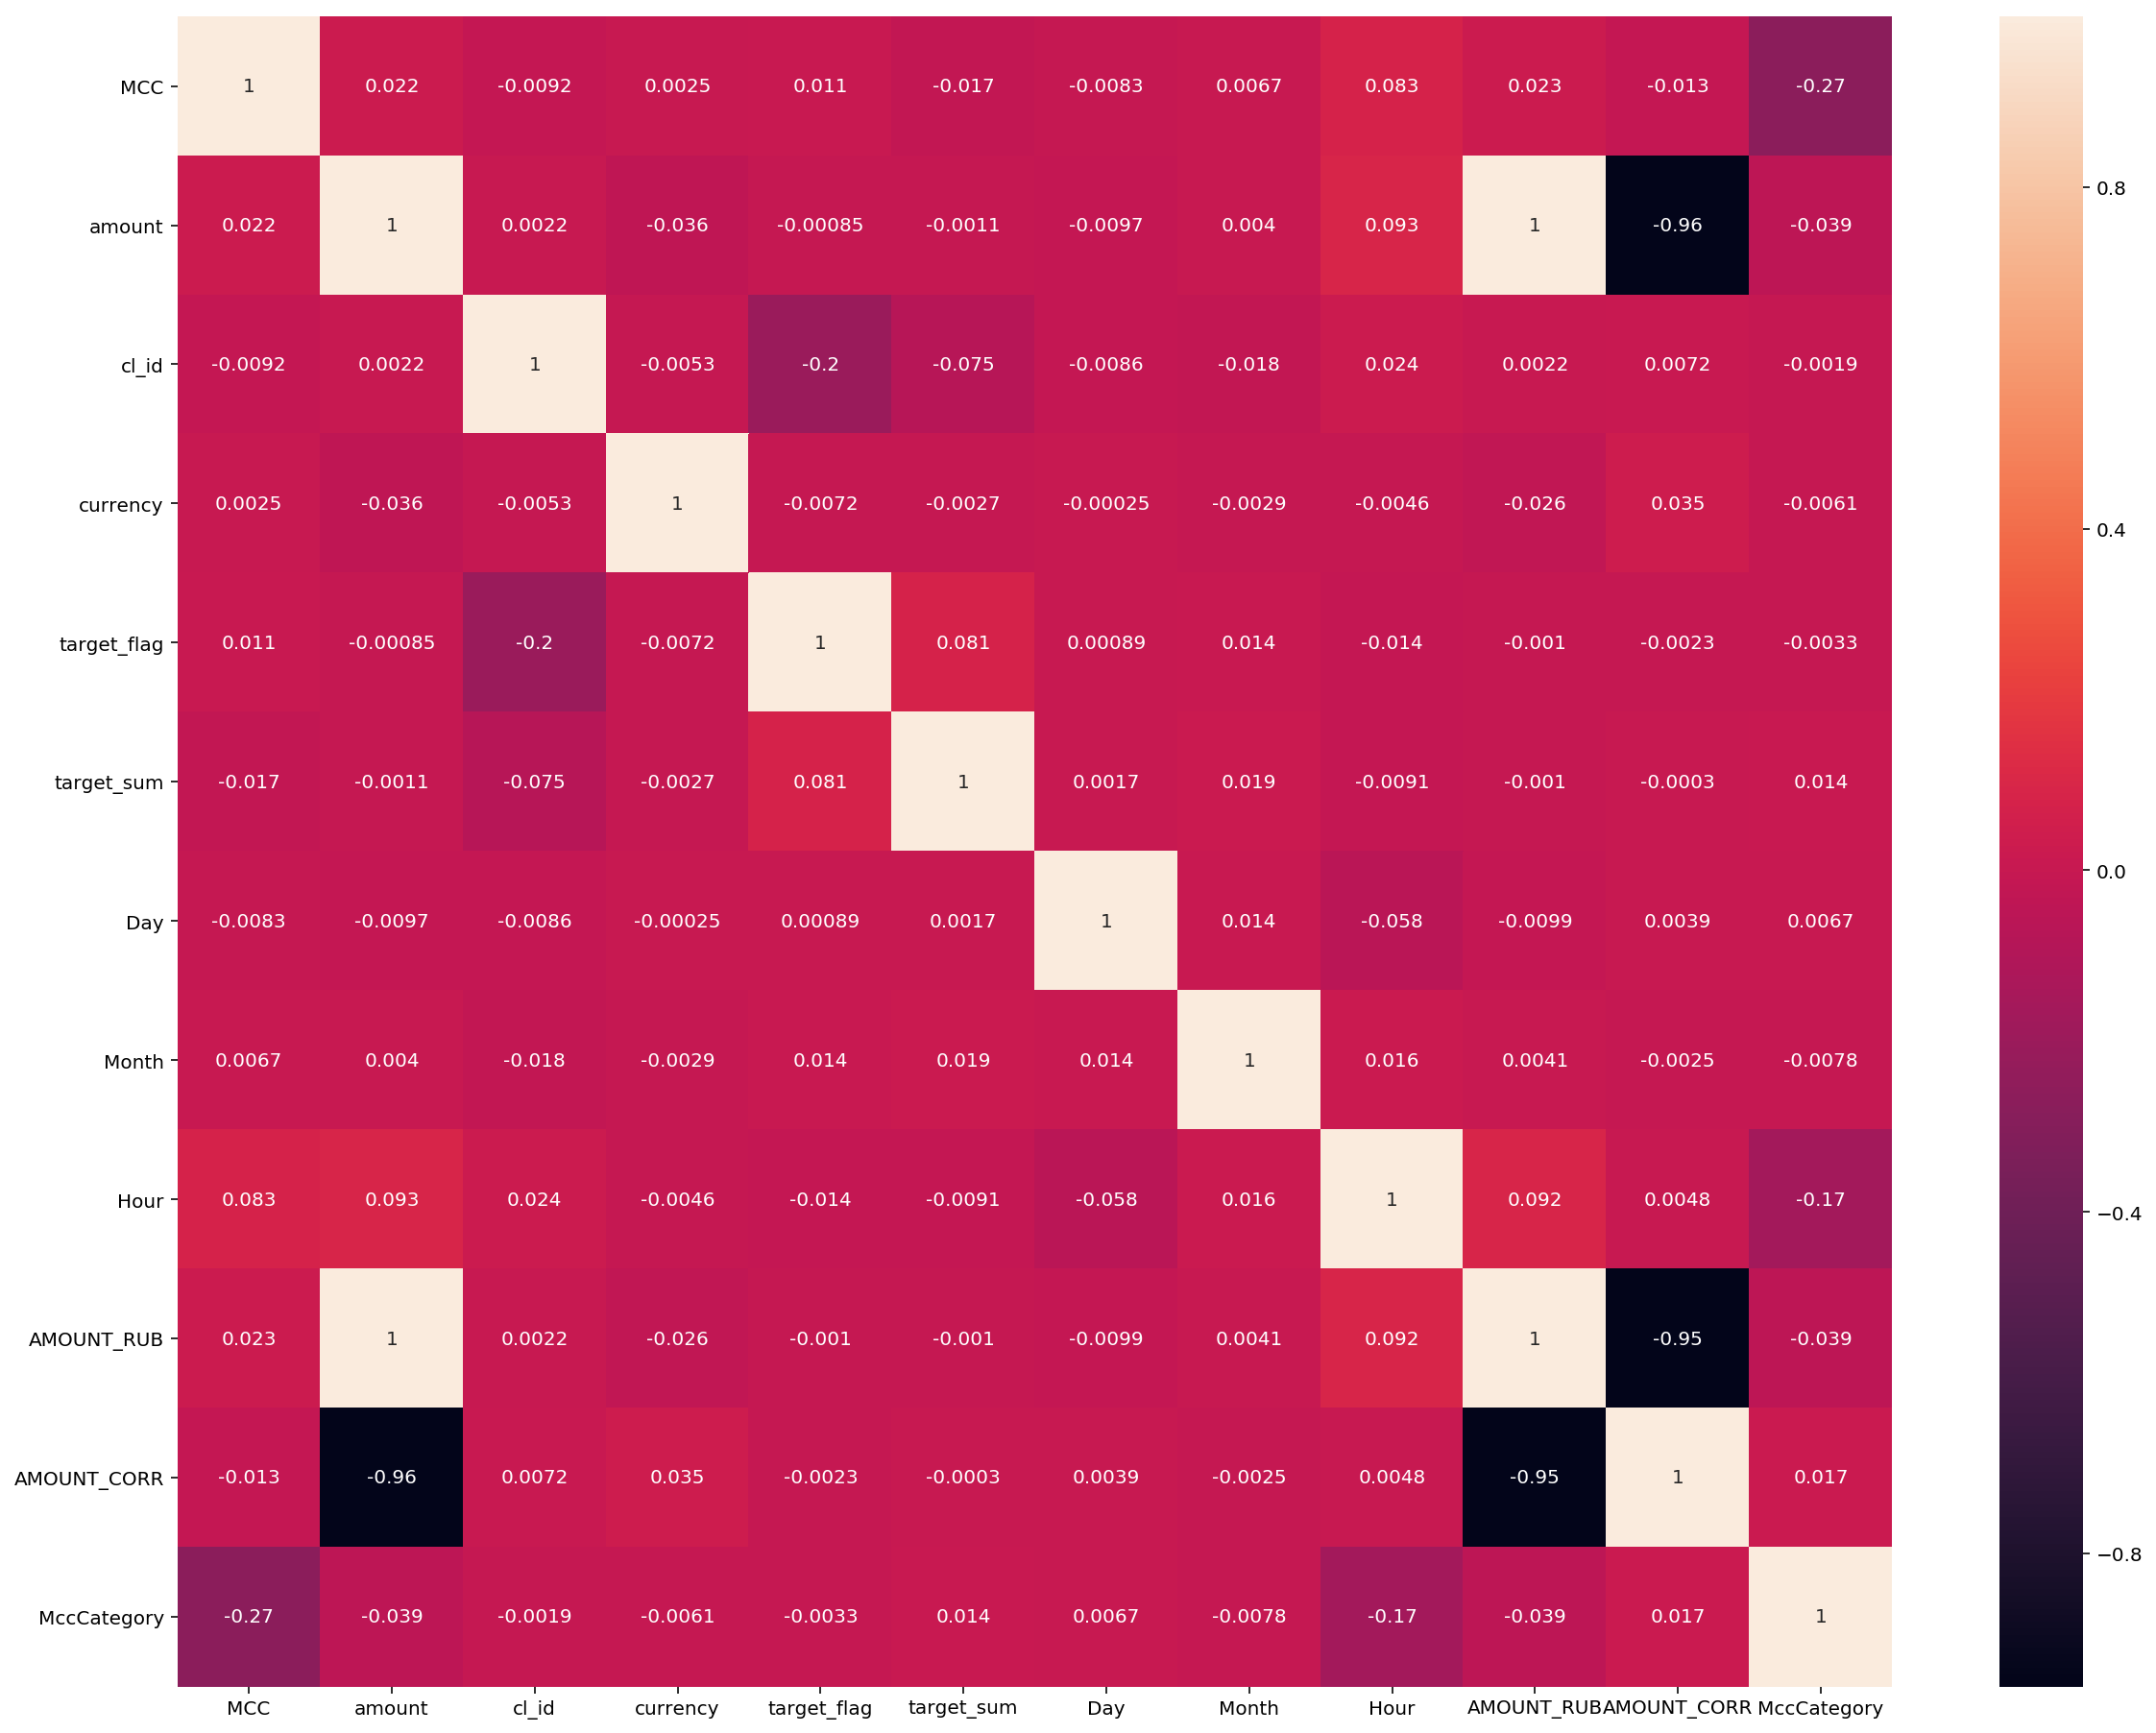

In [623]:
plt.figure(figsize=(20, 16))

corr = train_full_df.corr()
sns.heatmap(corr, annot=True, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Разделяем выборки

In [624]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

y = train_full_df['target_flag']
train_full_df.drop(columns='target_flag', inplace=True)

In [625]:
X_train, X_test, Y_train, Y_test = train_test_split(train_full_df[::50], y[::50], test_size=0.3)

In [626]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X_train_labeled = X_train.copy()

cat_feat = X_train.columns
for column in cat_feat:
    X_train_labeled[column] = le.fit_transform(X_train[column])

Y_train = le.fit_transform(Y_train)

In [627]:
#Шкалирование данных
from sklearn.preprocessing import StandardScaler

columns = X_train_labeled.columns
scaler = StandardScaler()
scaler.fit(X_train_labeled)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [628]:
X_train_imputed_scaled = scaler.transform(X_train_labeled)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [629]:
X_train.shape

(14124, 18)

## Применение Lasso

In [630]:
lasso =  Lasso(alpha=0.5);
lasso.fit(X_train_imputed_scaled, Y_train);

In [631]:
print('R^2 is {}'.format(lasso.score(X_train_imputed_scaled, Y_train)))

R^2 is 0.0


In [632]:
lasso.coef_

array([ 0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
        0.,  0.,  0., -0., -0.])

In [633]:
lasso.intercept_

0.3175446049277825

## Применение РСА

In [634]:
pca = PCA().fit(X_train_imputed_scaled,Y_train_labeled)

Text(0,0.5,'explained_variance_ratio')

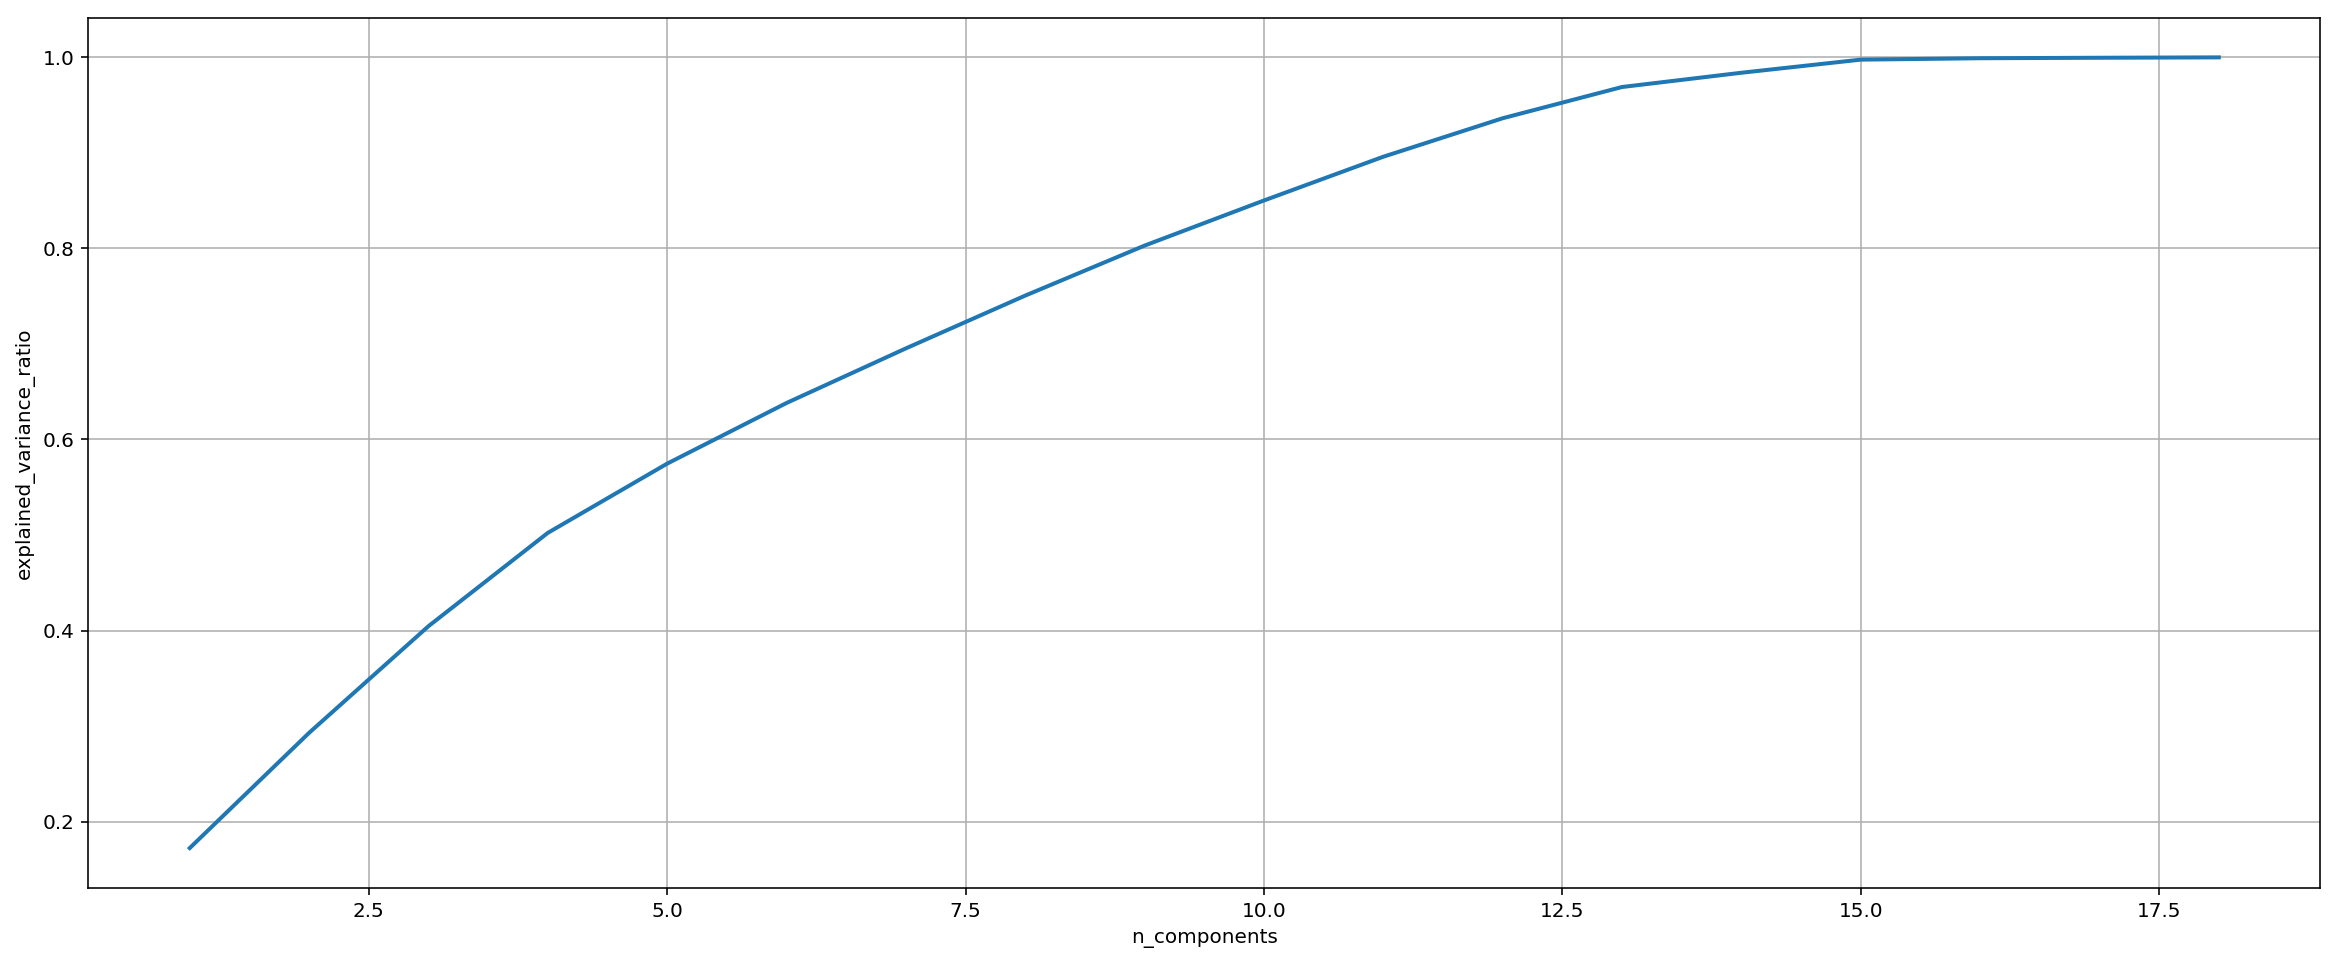

In [635]:
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')

In [636]:
X_train_pca = pca.transform(X_train_imputed_scaled)
X_train_pca

array([[-2.33739687e-01, -8.77212299e-01, -3.03861180e-01, ...,
         7.25350948e-03, -1.86530029e-02,  1.44231341e-01],
       [ 2.16904427e+00, -1.44835731e+00, -5.61691548e-01, ...,
         1.02688696e-01,  2.18466216e-02, -1.63755627e-03],
       [-1.56514337e+00,  7.73648651e-01, -9.67417635e-01, ...,
        -1.24012415e-02, -1.72677499e-02,  1.50284455e-02],
       ...,
       [ 1.82036497e+00, -3.47809694e+00, -3.46467492e-01, ...,
         3.43067692e-02,  1.67796259e-02,  1.05089694e-02],
       [-2.18966024e+00, -2.25788171e-01,  2.13889189e+00, ...,
        -1.69976335e-02, -5.98943769e-03,  9.52717594e-03],
       [ 2.30164138e+00, -1.33997895e+00, -5.93442338e-01, ...,
         1.05346911e-02, -2.62085078e-03,  7.86650840e-02]])

## Random Forest Classifier

In [637]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#params = [ {'max_depth': list( range(1, 20) )} ]
#gs = GridSearchCV( RandomForestClassifier(), param_grid = params, scoring = 'accuracy', return_train_score = False)
#gs.fit(X_train_pca, Y_train )

In [638]:
#gs.best_params_

In [639]:
clf_etc = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=5, max_features=0.8, n_jobs=-1)
clf_etc.fit(X_train_pca, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [640]:
y_hat = clf_etc.predict(X_train_pca)
print("Accuracy score", accuracy_score(Y_train, y_hat))

Accuracy score 0.9828660436137072


In [641]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

ROC AUC: 0.9988


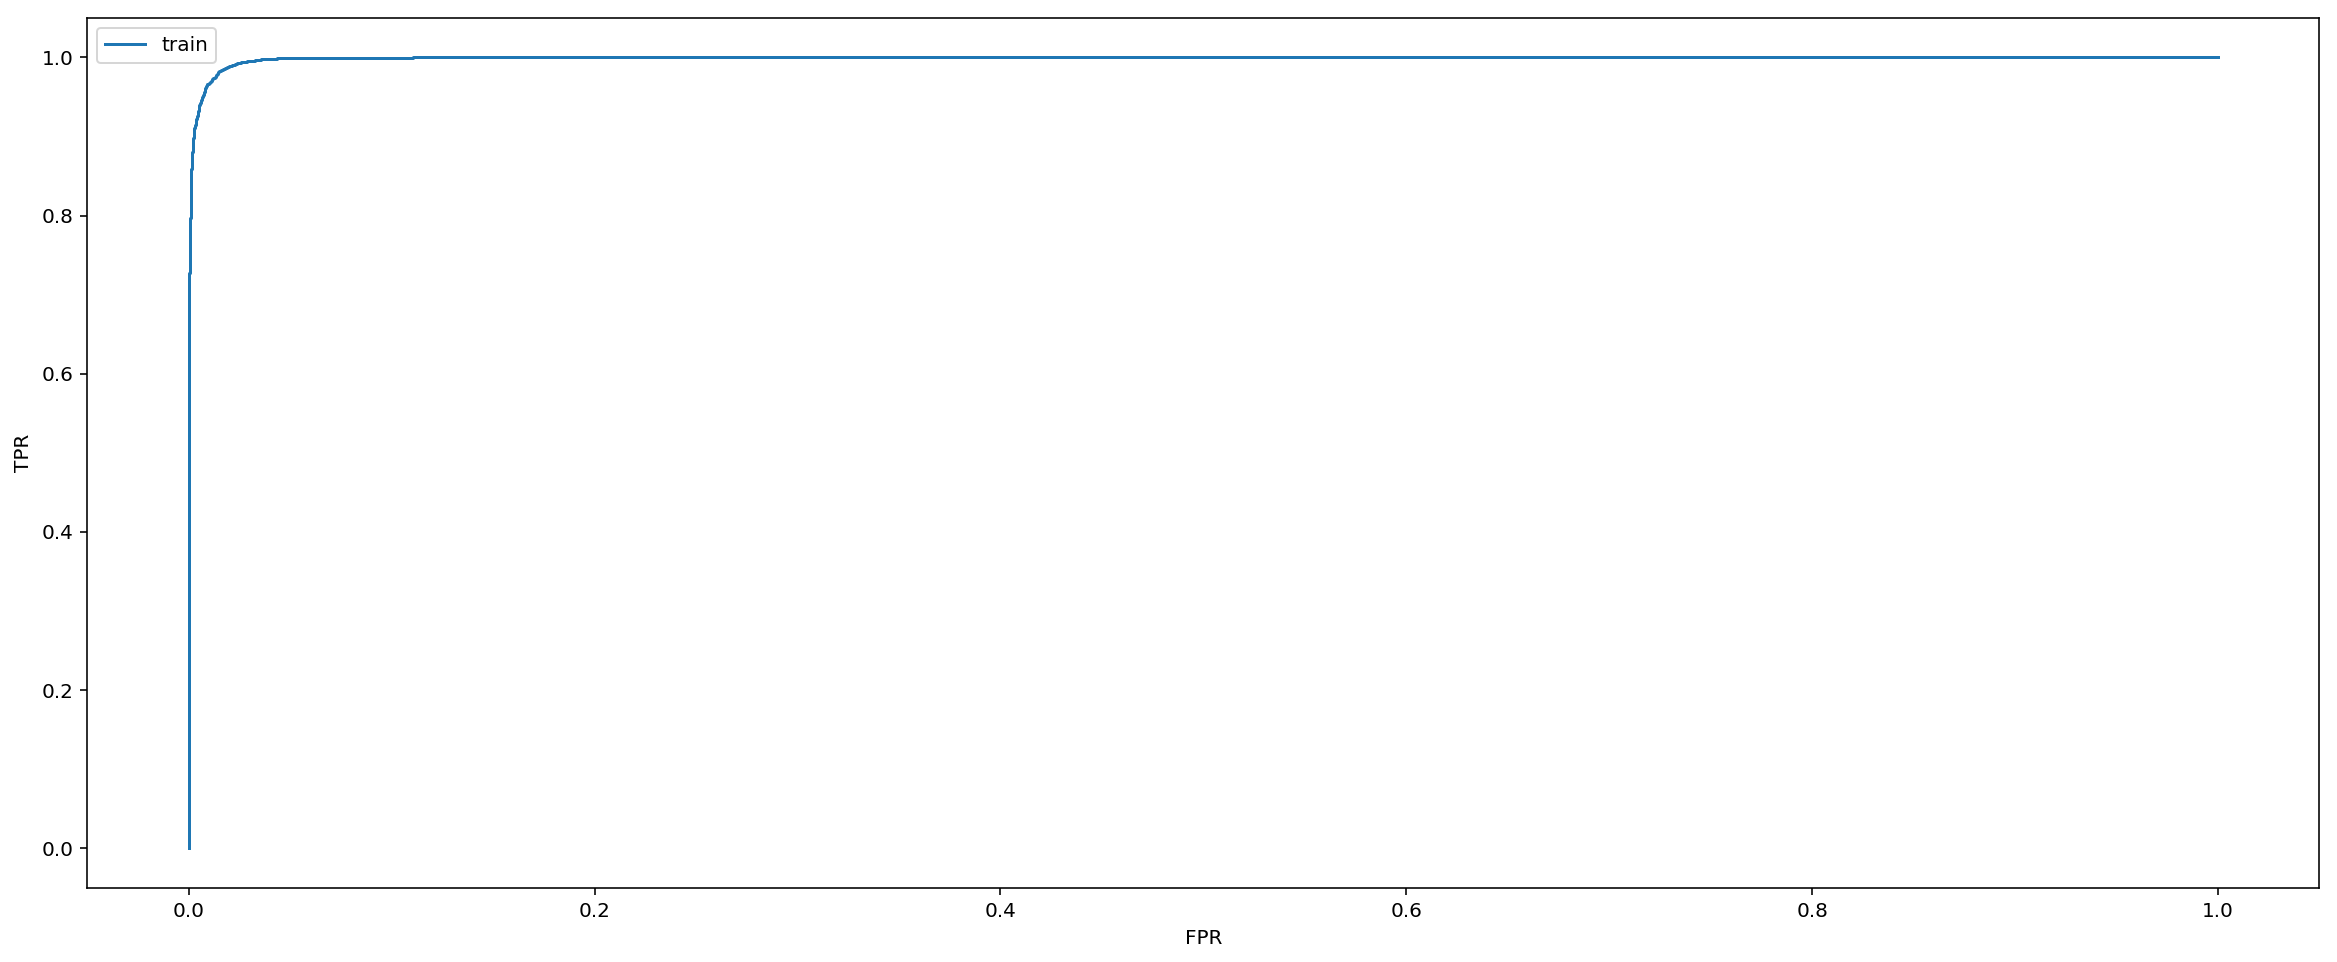

In [642]:
y_pred_rfc = clf_etc.predict_proba(X_train_pca)[:, 1]

calc_auc(Y_train, y_pred_rfc, 'train')

plt.legend();

## Logistic Regression

In [643]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_pca,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [644]:
y_hat = lr.predict(X_train_pca)
print("Accuracy score", accuracy_score(Y_train, y_hat))

Accuracy score 0.7789578023222883


ROC AUC: 0.8630


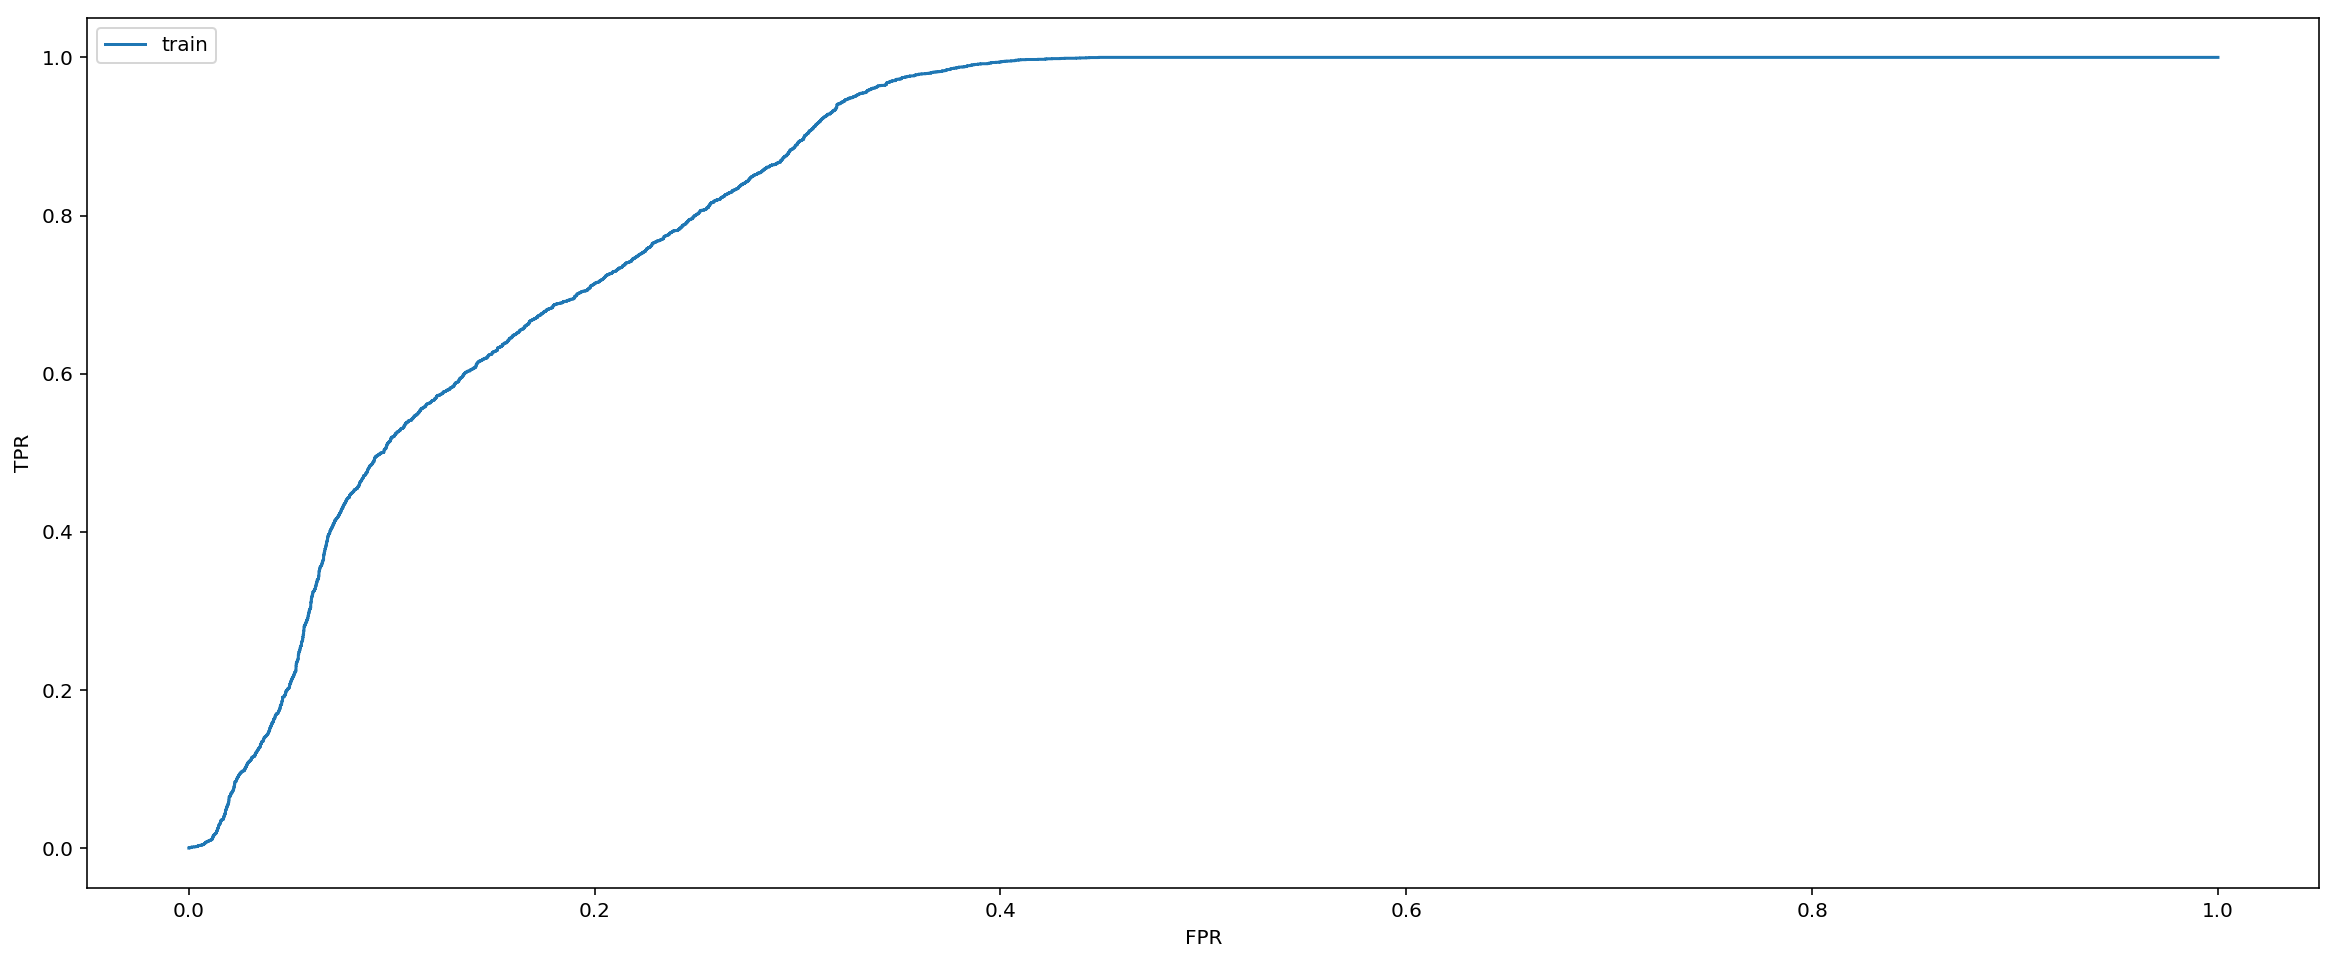

In [645]:
y_pred_rfc = lr.predict_proba(X_train_pca)[:, 1]
calc_auc(Y_train, y_pred_rfc, 'train')
plt.legend();